In [45]:
# Importing libraries necessary for EDA (Exploratory Data Analysis)
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
#importing models from scikit learn 
from sklearn import svm #Support Vector Machine
from xgboost import XGBClassifier #XGBoost
from sklearn.ensemble import RandomForestClassifier #Random Forest
#Importing hypertuning libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## 1. Data Loading 

In [5]:
# Using pandas read_csv() function to read the csv file and the head function to take a look at the first 5 rows of the dataset
df = pd.read_csv(r"/home/laith-saeed/Desktop/medical_project/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.shape

(768, 9)

* The dataset is composed of **9 columns and 768 rows**.

The next step is to take a look at the validity of the dataset. I will check for null values and impute using mean or median as per the distribution of the data for any null values.

In [7]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

* There are no null values in the dataset. 

In [8]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

The target variable being predicted is the **Outcome** column (also known as **Y or dependent variable**). 



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


* The data is composed of all numerical values with the rows being in either an `int64` or `float64 `data type.
I will take a look at some summary statitics for the data to see if there are any irregularities.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


* One thing that jumps out at me is the standard deviation valie for the `Insulin` column. The average value is **79.80 while the deviation is 115.2**. 
* The `skin thickness` is another variable where the deviation is a little too close to the mean.

## 2. Data Preprocessing 


The next step of the EDA process would be to plot boxplots to look at the Outliars in the dataset and then writing a function to clean them out as having no outliars is supposed to increase the accuracy of my SVM model being used for this dataset. This will also be compared later on. 



['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


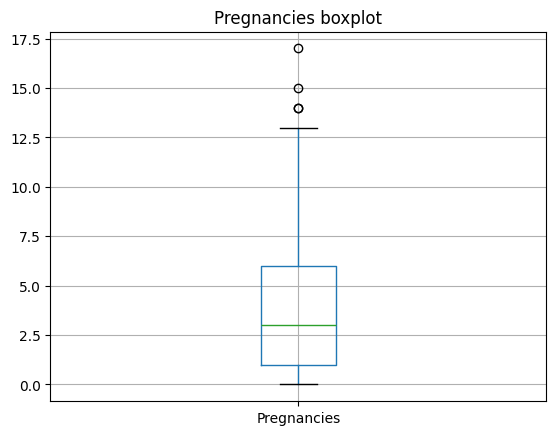

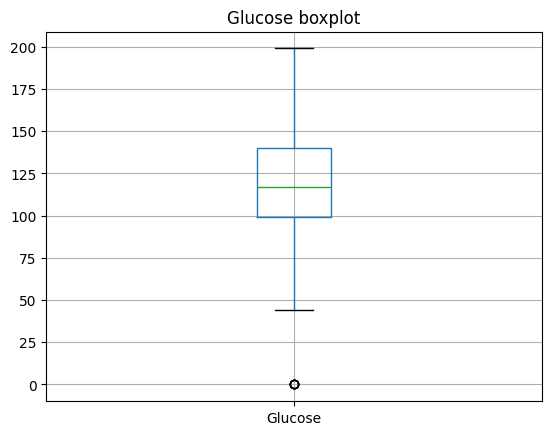

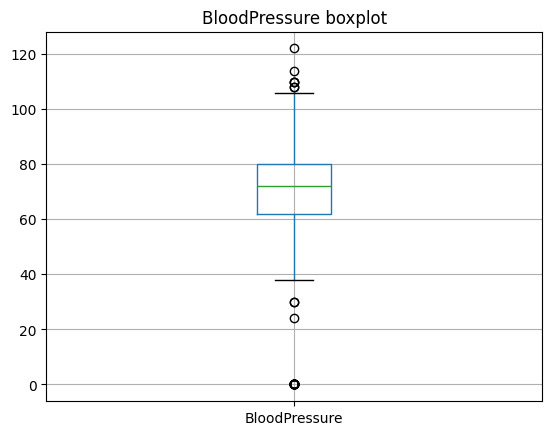

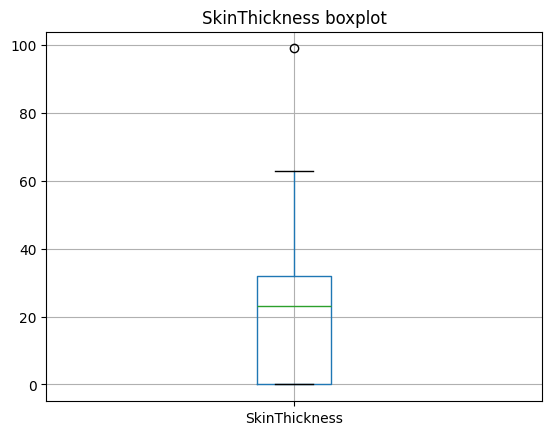

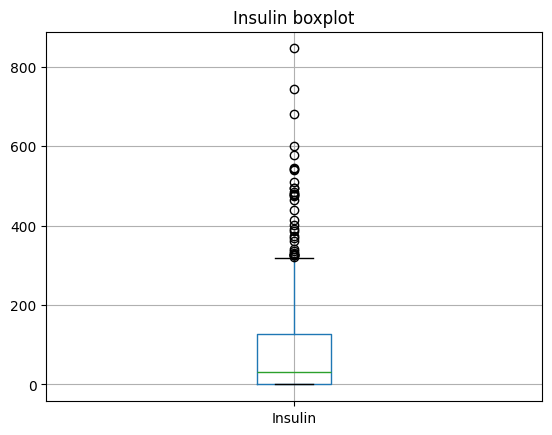

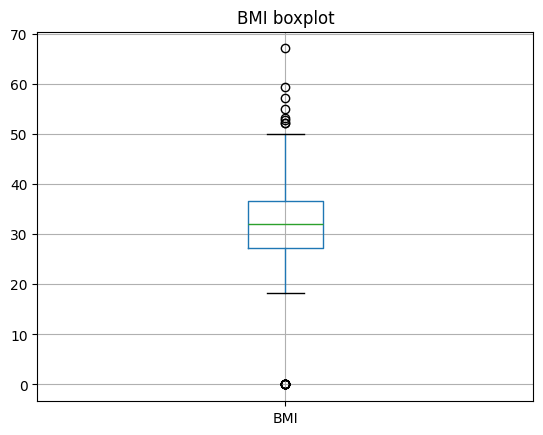

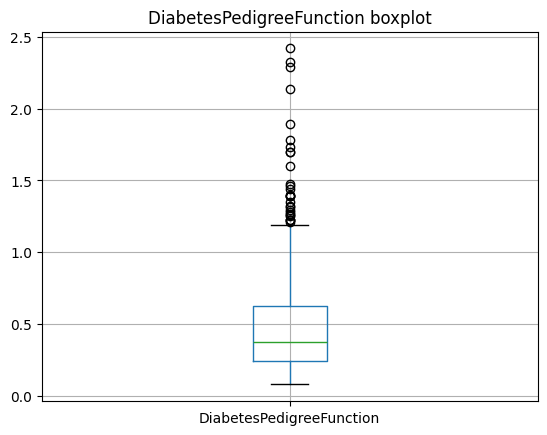

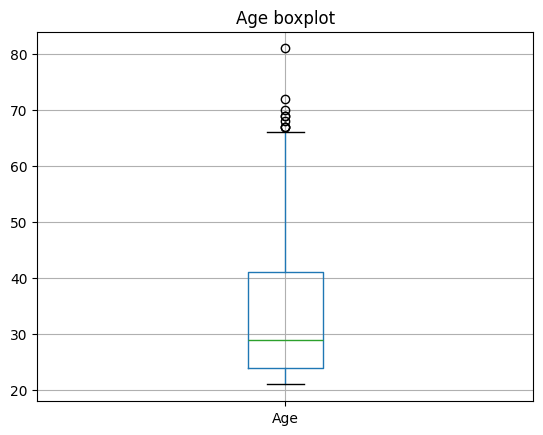

In [11]:
columns = df.columns.tolist()
print(columns)
columns = columns[:-1]
columns ## Removing the Outcome column from the list of columns as the outcome column is the target variable
for col in columns:
    df.boxplot(column=col)
    plt.title(f"{col} boxplot")
    plt.show()

* Our initial hunch about the **Insulin** column deviation was correct as we can observe many outliers as per the boxplot above. Surprisingly there was alot of outliars observed for other variables as well. 
The next step would be cleaning out our data by removing the outliers. This is done below. 


In [12]:
def outliar_removal(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_n_o = df.copy()

# Iterating through rows in the dataset and removing outliars
for col in columns:
    df_n_o= outliar_removal(df_n_o, col)
    print(f"Columns: {col}")
    print(f"Number of rows after outliar removal: {df_n_o.shape[0]}")
    print(f"Number of rows removed: {df.shape[0] - df_n_o.shape[0]}")

Columns: Pregnancies
Number of rows after outliar removal: 764
Number of rows removed: 4
Columns: Glucose
Number of rows after outliar removal: 759
Number of rows removed: 9
Columns: BloodPressure
Number of rows after outliar removal: 714
Number of rows removed: 54
Columns: SkinThickness
Number of rows after outliar removal: 713
Number of rows removed: 55
Columns: Insulin
Number of rows after outliar removal: 686
Number of rows removed: 82
Columns: BMI
Number of rows after outliar removal: 676
Number of rows removed: 92
Columns: DiabetesPedigreeFunction
Number of rows after outliar removal: 647
Number of rows removed: 121
Columns: Age
Number of rows after outliar removal: 636
Number of rows removed: 132


* There were a total of **132 records** removed as outliars out of the original **768 records**. 
* The model will be applied to the original dataset with the the outliars as well as the `df_n_o` dataset in order to see the effect of outliars on our model accuracy score. 
The next step will be to contruct heatmaps to see the correlation of the various dependent variables and the Outcome column. 

In [15]:
sns.heatmap(df.corr(), annot = True)

<Axes: >

In [16]:
sns.heatmap(df_n_o.corr(), annot = True)


<Axes: >

### Splitting the Data 

In [17]:
X = df.drop('Outcome', axis = 1)
y = df['Outcome']
X_n_o = df_n_o.drop('Outcome', axis = 1)
y_n_o = df_n_o['Outcome']

Scaling the data(Standardization)

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()
std = scaler.fit_transform(X)
std_n_o = scaler.fit_transform(X_n_o)

In [20]:
X= std 
X_n_o = std_n_o


# Splitting the data into train and test

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y,random_state = 42)
#other df without outliars
X_train_n_o, X_test_n_o, y_train_n_o, y_test_n_o = train_test_split(X_n_o, y_n_o, test_size = 0.2, stratify= y_n_o,random_state = 42)


In [22]:
print(df.shape)
print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(768, 9)
(768, 8) (614, 8) (154, 8)
(768,) (614,) (154,)


In [23]:
print(df_n_o.shape)
print(X_n_o.shape, X_train_n_o.shape, X_test_n_o.shape)
print(y_n_o.shape, y_train_n_o.shape, y_test_n_o.shape)

(636, 9)
(636, 8) (508, 8) (128, 8)
(636,) (508,) (128,)


## 3. Model Selection 

The support vector machine model will be the first model selected to Classify Outcome of the test records. 

# Hyperparameter tuning

#### GridSearchCV with SVM 

In [43]:
#Define the grid of hyperparameters
param_grid = {'C': [0.1, 1, 10, 100, 1000],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf', 'poly', 'sigmoid'],
               'degree': [2, 3, 4, 5] }

#create the the svm model
model = svm.SVC(random_state=42)

#create a gridsearchCV of the model 
GridSearch= GridSearchCV(model, param_grid, refit = True, verbose = 2, cv = 5, n_jobs= -1)
#fit the model 
GridSearch.fit(X_train, y_train)
GridSearch.fit(X_train_n_o, y_train_n_o)
#use the ebst model for predictions

best = GridSearch.best_estimator_
y_pred = best.predict(X_test)
y_pred_n_o = best.predict(X_test_n_o)
#Evaluating the model 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_test_n_o, y_pred_n_o))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...............C=0.1, degree=2, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...........C=0.1, degree=2, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..............C=0.1, degree=2, gamma=1, kernel=poly; total time=   0.0s
[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.1, degree=2, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .............C=0.1, degree=2, gamma=

* Removing outliers does have an effect on accuracy score raising it by 7.7%. The highest accuracy predicted by our models thus far has been 79.7% still not at the goal of 85%.
* There would be an two things of the top of my head: using a different model such as XGBoost  or Random Forest and changing the criterion for Hyperparameter tuning. The GridSearch method although exhaustive takes a lot of time to come up with a response. The previous cell took over 40 minutes to run. 

For the next attempt I will be diving into Randomized SearchCV  which works by finding the hyperparameters by randomly sampling combinations. This hyperparameter tuning tehcnique is suitable for larger grids. 


## Random Search CV 

#### RandomizedSearchCV with SVC 

In [ ]:

from scipy.stats import randint


#Define the grid of hyperparameters
param_dist = {'C': [0.1, 1, 10, 100, 1000, 10000], 
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
                'kernel': ['rbf', 'poly', 'sigmoid'],
               'degree': [5, 6, 7, 8, 9, 10, 11, 12]}

#create the the svm model
model = svm.SVC(random_state= 42)

#create a gridsearchCV of the model 
random_search = RandomizedSearchCV(model, param_distributions = param_dist, refit = True, verbose = 2, cv = 5, n_jobs= -1, n_iter = 30)
#fit the model 
random_search.fit(X_train, y_train)
random_search.fit(X_train_n_o, y_train_n_o)
#use the ebst model for predictions

best = random_search.best_estimator_
print(random_search.best_params_)
print(random_search.best_score_)
y_pred = best.predict(X_test)
y_pred_n_o = best.predict(X_test_n_o)
#Evaluating the model 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_test_n_o, y_pred_n_o))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ......C=0.1, degree=10, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ............C=1, degree=6, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......C=0.1, degree=10, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.1, degree=10, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.1, degree=10, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ......C=0.1, degree=10, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ............C=1, degree=6, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=6, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=6, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ............C=1, degree=6, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END .......C=100, degree=11, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .......C=100, degree=11, gamma=0.01, k

In [ ]:
# A parameter grid for XGBoost
params = {
    'n_estimators':[50, 200, 500],
    'booster': ['gbtree', 'gblinear', 'dart'],
    'min_child_weight':[1,3,5,7], 
    'gamma':[0.01,0.1,0.3,0.5,0.7,0.9],  
    'subsample':[0.6,0.8,1],
    'colsample_bytree':[0.6,0.8,1], 
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1,0.3],
    'eval_metric': ['error'],
}


#create the the svm model
model = XGBClassifier(objective= 'multi:softmax', random_state=42)
#create a gridsearchCV of the model 
random_search = RandomizedSearchCV(model, param_distributions = params, refit = True, verbose = 2, cv = 5, n_jobs= -1, n_iter = 30)
#fit the model 
random_search.fit(X_train, y_train)
random_search.fit(X_train_n_o, y_train_n_o)
#use the ebst model for predictions

best = random_search.best_estimator_
print(random_search.best_params_)
print(random_search.best_score_)
y_pred = best.predict(X_test)
y_pred_n_o = best.predict(X_test_n_o)
#Evaluating the model 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_test_n_o, y_pred_n_o))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END booster=gblinear, colsample_bytree=0.3, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.3, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.3, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.3, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.3, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END booster=gbtree

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=200, subsample=0.9; total time=   1.1s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=200, subsample=0.9; total time=   1.2s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=200, subsample=0.9; total time=   1.2s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=200, subsample=0.9; total time=   1.2s
[CV] END booster=gblinear, colsample_bytree=0.9, eval_metric=error, gamma=0.6, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=400, subsample=0.8; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.9, eval_metric=error, gamma=0.6, learning_rate=0.3, max

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.4; total time=   2.5s
[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.4; total time=   2.6s
[CV] END booster=gbtree, colsample_bytree=0.7, eval_metric=error, gamma=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400, subsample=1.0; total time=   0.0s
[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.4; total time=   2.7s
[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.4; total time=   2.7s
[CV] END booster=gbtree, colsample_bytree=0.7, eval_metric=error, gamma=0.6, learning_rate=0.1, max_dep

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=gbtree, colsample_bytree=0.6, eval_metric=error, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=500, subsample=0.5; total time=   0.1s
[CV] END booster=dart, colsample_bytree=0.4, eval_metric=error, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END booster=dart, colsample_bytree=0.4, eval_metric=error, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END booster=gbtree, colsample_bytree=0.6, eval_metric=error, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=500, subsample=0.5; total time=   0.1s
[CV] END booster=dart, colsample_bytree=0.4, eval_metric=error, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END booster=gblinear, colsample_bytree=0.6, eval_metric=error, gamma=0.4, learning_rate=0.3, max

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END booster=gbtree, colsample_bytree=0.6, eval_metric=error, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=500, subsample=0.5; total time=   0.1s
[CV] END booster=gbtree, colsample_bytree=0.6, eval_metric=error, gamma=0.2, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=500, subsample=0.5; total time=   0.1s
[CV] END booster=gbtree, colsample_bytree=0.3, eval_metric=error, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END booster=gbtree, colsample_bytree=0.3, eval_metric=error, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=200, subsample=0.6; total time=   0.0s
[CV] END booster=dart, colsample_bytree=0.4, eval_metric=error, gamma=0.5, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END booster=gbtree, colsample_bytree=0.3, eval_metric=error, gamma=0.5, learning_rate=0.01

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=gblinear, colsample_bytree=0.4, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.4, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.8, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.4, eval_metric=error, gamma=0.2, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.8, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.4, eval_metric=error, gamma=0.2, learni

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=gbtree, colsample_bytree=0.4, eval_metric=error, gamma=0.7, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=300, subsample=0.2; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.1, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=400, subsample=0.1; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.1, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=400, subsample=0.1; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.1, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=400, subsample=0.1; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.1, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=400, subsample=0.1; total time=   0.0s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.2, learning_rat

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END booster=dart, colsample_bytree=0.7, eval_metric=error, gamma=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   2.7s
[CV] END booster=dart, colsample_bytree=0.7, eval_metric=error, gamma=0.9, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.6; total time=   2.7s
[CV] END booster=gbtree, colsample_bytree=0.7, eval_metric=error, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END booster=gbtree, colsample_bytree=0.7, eval_metric=error, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END booster=gbtree, colsample_bytree=0.7, eval_metric=error, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, subsample=0.1; total time=   0.0s
[CV] END booster=gbtree, colsample_bytree=0.7, eval_metric=error, gamma=0.1, learning_rate=0.2, max

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.6, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   1.0s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.6, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   1.0s
[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.8, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.3; total time=   0.3s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.6, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   1.1s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.6, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=200, subsample=0.1; total time=   1.2s
[CV] END booster=dart, colsample_bytree=0.1, eval_metric=error, gamma=0.8, learning_rate=0.1, max_depth=9

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END booster=gblinear, colsample_bytree=0.9, eval_metric=error, gamma=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=400, subsample=0.3; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.9, eval_metric=error, gamma=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=400, subsample=0.3; total time=   0.0s
[CV] END booster=gbtree, colsample_bytree=1.0, eval_metric=error, gamma=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END booster=gblinear, colsample_bytree=0.9, eval_metric=error, gamma=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=400, subsample=0.3; total time=   0.0s
[CV] END booster=gblinear, colsample_bytree=0.9, eval_metric=error, gamma=0.7, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=400, subsample=0.3; total time=   0.0s
[CV] END booster=gbtree,

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.4; total time=   1.0s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.4; total time=   1.0s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.4; total time=   1.1s
[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.3; total time=   1.1s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   2.1s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.3, learning_rate=0.3, max_depth=

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.1, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.4; total time=   1.0s
[CV] END booster=gbtree, colsample_bytree=0.4, eval_metric=error, gamma=0.9, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END booster=gbtree, colsample_bytree=0.3, eval_metric=error, gamma=0.7, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=200, subsample=0.4; total time=   0.0s
[CV] END booster=gbtree, colsample_bytree=0.4, eval_metric=error, gamma=0.9, learning_rate=0.01, max_depth=7, min_child_weight=1, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END booster=dart, colsample_bytree=0.8, eval_metric=error, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   2.3s
[CV] END booster=gbtree, colsample_bytree=0.3, eval_metric=error, gamma=0.7, learning_rate=0.3, m

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.3; total time=   1.0s
[CV] END booster=gbtree, colsample_bytree=0.4, eval_metric=error, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=5, n_estimators=400, subsample=0.4; total time=   0.1s
[CV] END booster=dart, colsample_bytree=0.3, eval_metric=error, gamma=0.5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.3; total time=   1.0s
[CV] END booster=gbtree, colsample_bytree=0.5, eval_metric=error, gamma=0.7, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.5; total time=   0.1s
[CV] END booster=gbtree, colsample_bytree=0.5, eval_metric=error, gamma=0.7, learning_rate=0.1, max_depth=7, min_child_weight=3, n_estimators=400, subsample=0.5; total time=   0.1s
[CV] END booster=dart, colsample_bytree=0.4, eval_metric=error, gamma=0.2, learning_rate=0.3, max

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=dart, colsample_bytree=0.4, eval_metric=error, gamma=0.2, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.4; total time=   2.1s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.8, learning_rate=0.01, max_depth=9, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   2.3s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.8, learning_rate=0.01, max_depth=9, min_child_weight=3, n_estimators=300, subsample=0.9; total time=   2.4s
[CV] END booster=gbtree, colsample_bytree=1.0, eval_metric=error, gamma=0.7, learning_rate=0.3, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.3; total time=   0.1s
[CV] END booster=gbtree, colsample_bytree=1.0, eval_metric=error, gamma=0.7, learning_rate=0.3, max_depth=9, min_child_weight=5, n_estimators=500, subsample=0.3; total time=   0.1s
[CV] END booster=gbtree, colsample_bytree=1.0, eval_metric=error, gamma=0.7, learning_rate=0.3, max

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=dart, colsample_bytree=1.0, eval_metric=error, gamma=0.6, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=400, subsample=0.2; total time=   5.1s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=200, subsample=0.9; total time=   1.6s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.3, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=200, subsample=0.9; total time=   1.6s
[CV] END booster=dart, colsample_bytree=0.6, eval_metric=error, gamma=0.7, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=400, subsample=0.6; total time=   5.9s
[CV] END booster=dart, colsample_bytree=0.1, eval_metric=error, gamma=0.7, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=400, subsample=0.5; total time=   5.7s
[CV] END booster=dart, colsample_bytree=0.1, eval_metric=error, gamma=0.7, learning_rate=0.2, max_dept

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.3; total time=   3.6s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.3; total time=   3.1s
[CV] END booster=gblinear, colsample_bytree=0.6, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.2; total time=   0.1s
[CV] END booster=gblinear, colsample_bytree=0.6, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.2; total time=   0.1s
[CV] END booster=gblinear, colsample_bytree=0.6, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.2; total time=   0.1s


/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:15

[CV] END booster=gblinear, colsample_bytree=0.6, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.2; total time=   0.1s
[CV] END booster=gblinear, colsample_bytree=0.6, eval_metric=error, gamma=0.4, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, subsample=0.2; total time=   0.1s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.3; total time=   3.1s


/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END booster=dart, colsample_bytree=0.6, eval_metric=error, gamma=0.7, learning_rate=0.01, max_depth=5, min_child_weight=7, n_estimators=400, subsample=0.6; total time=   5.6s
[CV] END booster=dart, colsample_bytree=0.1, eval_metric=error, gamma=0.7, learning_rate=0.2, max_depth=9, min_child_weight=5, n_estimators=400, subsample=0.5; total time=   5.7s
[CV] END booster=gblinear, colsample_bytree=0.1, eval_metric=error, gamma=0.6, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.5; total time=   0.0s


/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.7, learning_rate=0.2, max_depth=7, min_child_weight=7, n_estimators=500, subsample=0.6; total time=   9.2s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.3; total time=   2.7s
[CV] END booster=dart, colsample_bytree=0.5, eval_metric=error, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=7, n_estimators=500, subsample=0.8; total time=   7.8s
[CV] END booster=dart, colsample_bytree=0.2, eval_metric=error, gamma=0.3, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=300, subsample=0.3; total time=   3.3s
[CV] END booster=dart, colsample_bytree=0.5, eval_metric=error, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=7, n_estimators=500, subsample=0.8; total time=   8.9s
[CV] END booster=dart, colsample_bytree=0.5, eval_metric=error, gamma=0.1, learning_rate=0.2, max_depth

/home/laith-saeed/Desktop/medical_project/venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:29:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


In [47]:
# A parameter grid for RandomForestClassifier 
params = {
    'n_estimators': [50, 100, 200, 300, 400, 500],       # Number of trees
    'max_depth': [None, 10, 20, 30],           # Maximum depth
    'min_samples_split': [2, 5, 10],           # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],             # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None],    # Features to consider for each split
    'bootstrap': [True, False]                 # Whether to bootstrap samples
}



#create the the svm model
model = RandomForestClassifier(random_state=42)
#create a gridsearchCV of the model 
random_search = RandomizedSearchCV(model, param_distributions = params, refit = True, verbose = 2, cv = 2, n_jobs= -1, n_iter = 30, random_state=42)
#fit the model 
random_search.fit(X_train, y_train)
random_search.fit(X_train_n_o, y_train_n_o)
#use the ebst model for predictions

best = random_search.best_estimator_
print(random_search.best_params_)
print(random_search.best_score_)
y_pred = best.predict(X_test)
y_pred_n_o = best.predict(X_test_n_o)
#Evaluating the model 

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_test_n_o, y_pred_n_o))

Fitting 2 folds for each of 30 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=